### 導入函式庫

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import datetime 
import time
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 讀data並且拆分為train dataset和test dataset

In [15]:
path="/content/drive/MyDrive/Colab Notebooks/專題 - 黃春融 /LSTM/test/stock data/2890 (2).CSV"
df = pd.read_csv(path,index_col='date',)
df=df.dropna()
df.index = pd.to_datetime(df.index)
print(df)

UnicodeDecodeError: ignored

In [ ]:
test_periods = 30
train_data = df[:-test_periods].values
test_data = df[-test_periods:].values

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(train_data)
train_scaled = scaler.transform(train_data) # value: 0-1
train_scaled = torch.FloatTensor(train_scaled).to(device) # torch.Size([35, 1])
train_scaled = train_scaled.view(-1) # torch.Size([35])
print(train_scaled)

tensor([0.0079, 0.0081, 0.0077,  ..., 0.4323, 0.4048, 0.4169], device='cuda:0')


In [ ]:
def get_x_y_pairs(train_scaled, train_periods, prediction_periods):
  x_train = [train_scaled[i:i+train_periods] for i in range(len(train_scaled)-train_periods-prediction_periods+1)]
  y_train = [train_scaled[i+train_periods:i+train_periods+prediction_periods] for i in range(len(train_scaled)-train_periods-prediction_periods+1)]
  x_train = torch.stack(x_train).to(device)
  y_train = torch.stack(y_train).to(device)

  return x_train, y_train

train_periods = 180  # number of quarters for input
prediction_periods = test_periods  # test_periods=8
x_train, y_train = get_x_y_pairs(train_scaled, train_periods, prediction_periods)
# x_train: torch.Size([12, 16])
# y_train: torch.Size([12, 8])

### model

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(LSTM, self).__init__()
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size, hidden_size)
    self.linear = nn.Linear(hidden_size, output_size)
        
  def forward(self, x):
    self.hidden = (torch.zeros(1,1,self.hidden_size).to(device), torch.zeros(1,1,self.hidden_size).to(device))
    lstm_out, self.hidden = self.lstm(x.view(len(x),1,-1), self.hidden) 
    predictions = self.linear(lstm_out.view(len(x), -1))   
    return predictions[-1]

In [ ]:
model = LSTM(input_size=1, hidden_size=50, output_size=test_periods)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### train

In [ ]:
epochs = 1
model.train()
for epoch in range(epochs):
  for x, y in zip(x_train, y_train):
    x = x.to(device)
    y = y.to(device)
    y_hat = model(x)
    optimizer.zero_grad()
    loss = criterion(y_hat, y)
    loss.backward()
    optimizer.step()
        
  if (epoch+1)%100==0:
    print(f'epoch: {epoch:4} loss:{loss.item():10.8f}')

torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/專題 - 黃春融 /LSTM/test/stock data/LSTM_600epochs.pth')
print('Finished Training')

Finished Training


In [ ]:
pretrained_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/專題 - 黃春融 /LSTM/test/stock data/LSTM_600epochs.pth')
model_dict = model.state_dict()
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)
print("Finish loading parameter.")

Finish loading parameter.


In [ ]:
epochs = 1
model.train()
for epoch in range(epochs):
  for x, y in zip(x_train, y_train):
    x = x.to(device)
    y = y.to(device)
    y_hat = model(x)
    optimizer.zero_grad()
    loss = criterion(y_hat, y)
    loss.backward()
    optimizer.step()
  print(f'epoch: {epoch:4} loss:{loss.item():10.8f}')

torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/專題 - 黃春融 /LSTM/test/stock data/LSTM_610epochs.pth')
print('Finished Training')

epoch:    0 loss:0.00498310
Finished Training


### test

In [ ]:
model.eval()
with torch.no_grad():
    predictions = model(train_scaled[-train_periods:])

predictions = scaler.inverse_transform(np.array(predictions.reshape(-1,1).cpu())) # inverse transform -> no scaling 
print(predictions)

[[134.55382]
 [135.20183]
 [135.25032]
 [136.27579]
 [136.00562]
 [135.4554 ]
 [135.58597]
 [136.34892]
 [137.34062]
 [136.9408 ]
 [136.47084]
 [136.43901]
 [137.58278]
 [137.29254]
 [136.88992]
 [137.3241 ]
 [137.245  ]
 [138.60452]
 [137.58821]
 [136.82718]
 [137.09685]
 [137.98459]
 [137.4061 ]
 [136.9419 ]
 [136.00407]
 [135.08301]
 [134.17342]
 [134.5278 ]
 [132.56451]
 [131.56537]]


### 畫圖，不影響主程式


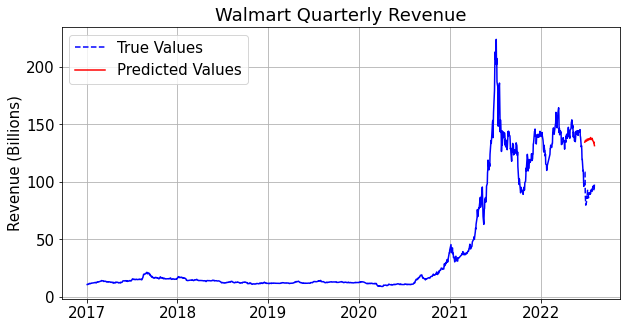

In [ ]:
x = [datetime.datetime.date(d) for d in df.index] #X = 時間
font = {'size'   : 15}  #字體大小 

matplotlib.rc('font', **font)

fig = plt.figure(figsize=(10,5)) 
plt.title('Walmart Quarterly Revenue') #標題大小
plt.ylabel('Revenue (Billions)')    #Y軸
plt.grid(True)             #是否需要網格狀
plt.plot(x[:-len(predictions)],     # 
         df.Value[:-len(predictions)],
         "b-")  # B = 藍色實線
plt.plot(x[-len(predictions):],
         test_data,
         "b--",
         label='True Values')
plt.plot(x[-len(predictions):], # 預測的8個資料
         predictions, # 預測線
         "r-",   
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)